In [12]:
import torch
import joblib
from src.data.data_loader import load_data, create_data_splits, create_data_loaders
from src.models.models import NeuralNetwork, LinearModels, XGBoostModel
from src.utils.training import (
    train_neural_network, train_neural_network_weighted,
    evaluate_model, predict, optimize_hyperparameters,
    train_neural_network_with_optimal_params
)
from src.utils.visualization import (
    plot_training_history, plot_predictions, plot_model_comparison,
    plot_feature_importance
)
from src.config.config import DEVICE, MODEL_PATHS
import numpy as np
from sklearn.preprocessing import StandardScaler

In [13]:
# load dataset 

X, y = load_data()

In [14]:
X.shape

(500, 448)

In [15]:
y.shape

(500, 1)

In [16]:
# split train and test dataset 
X_train, X_test, y_train, y_test = create_data_splits(X, y)

print("Train data - ",X_train.shape)
print("Test data  - ",X_test.shape)

Train data -  (400, 448)
Test data  -  (100, 448)


In [17]:
# data loaders used to train nn 

train_loader, test_loader = create_data_loaders(X_train, X_test, y_train, y_test)

In [18]:
models_results = []

## Linear Regression 

In [19]:
# initialize model 
linear_model = LinearModels.get_linear_regression()

In [20]:
linear_model.fit(X_train, y_train)

LinearRegression()

In [21]:
linear_metrics = evaluate_model(linear_model, X_train, X_test, y_train, y_test)

In [22]:
models_results.append(("Linear Regression", linear_metrics))

In [23]:
linear_metrics

{'rmse_train': 6.29215684105832e-14,
 'rmse_test': 9.335031262654006,
 'r2_train': 1.0,
 'r2_test': -10.399319810836612,
 'mae_train': 4.854450175173497e-14,
 'mae_test': 7.523130525799499}

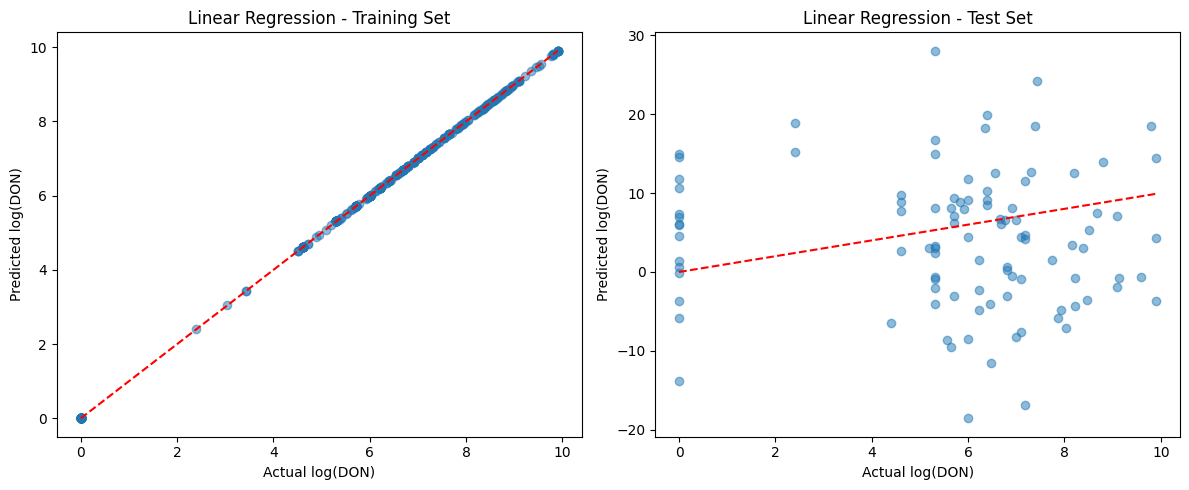

In [24]:
plot_predictions(y_train, predict(linear_model, X_train), 
                    y_test, predict(linear_model, X_test), 
                    "Linear Regression")

As we can see from the figure above (left one), it is obvious that it is overfitting the data. 

We can expect the test score to improve when we use regualrization

## Ridge regression

In [25]:
# initialize model
ridge_model = LinearModels.get_ridge_regression()

In [26]:
ridge_model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Ridge(random_state=42),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [27]:
# it performs hyperparamter tuning while training
# the arguments for hyperparameter tuning can be controlled in config.py 
print(f"Best Ridge alpha: {ridge_model.best_params_['alpha']}")

Best Ridge alpha: 100


alpha equal to 100 means it has performed high regularization

In [28]:
ridge_metrics = evaluate_model(ridge_model.best_estimator_, X_train, X_test, y_train, y_test)

ridge_metrics

{'rmse_train': 2.321355365464091,
 'rmse_test': 2.52464982560665,
 'r2_train': 0.3757413739650093,
 'r2_test': 0.16622343788589078,
 'mae_train': 1.800695315411531,
 'mae_test': 1.8721367885310576}

The metrics are way better than linear regression

In [29]:
models_results.append(("Ridge Regression", ridge_metrics))

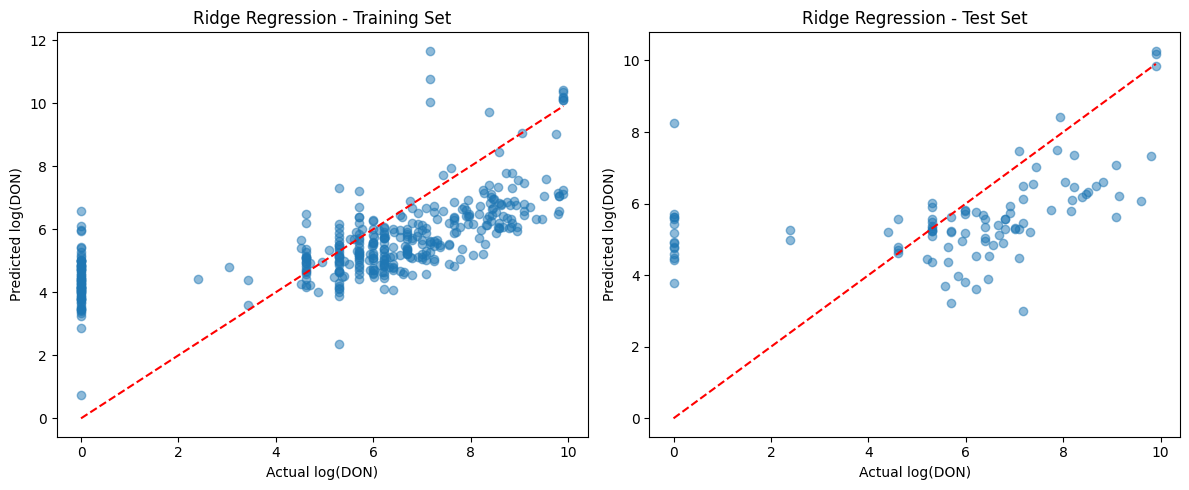

In [30]:
plot_predictions(y_train, predict(ridge_model.best_estimator_, X_train),
                    y_test, predict(ridge_model.best_estimator_, X_test),
                    "Ridge Regression")

## lasso regression 

In [31]:
# initializing the model 
lasso_model = LinearModels.get_lasso_regression()

In [32]:
lasso_model.fit(X_train, y_train)

/Users/hardikkamboj/anaconda3/envs/opencv_4_9/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.974e+01, tolerance: 2.892e+01
  model = cd_fast.enet_coordinate_descent(
/Users/hardikkamboj/anaconda3/envs/opencv_4_9/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.996e+01, tolerance: 2.711e+01
  model = cd_fast.enet_coordinate_descent(
/Users/hardikkamboj/anaconda3/envs/opencv_4_9/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(max_iter=10000, random_state=42, tol=0.01),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error')

In [35]:
print(f"Best Lasso alpha: {lasso_model.best_params_['alpha']}")

Best Lasso alpha: 0.1


In [36]:
lasso_metrics = evaluate_model(lasso_model.best_estimator_, X_train, X_test, y_train, y_test)
models_results.append(("Lasso Regression", lasso_metrics))

In [37]:
lasso_metrics

{'rmse_train': 2.6186422509912397,
 'rmse_test': 2.526849707088235,
 'r2_train': 0.20561024519144333,
 'r2_test': 0.1647697640103637,
 'mae_train': 2.0266388968410176,
 'mae_test': 1.8761489283503903}

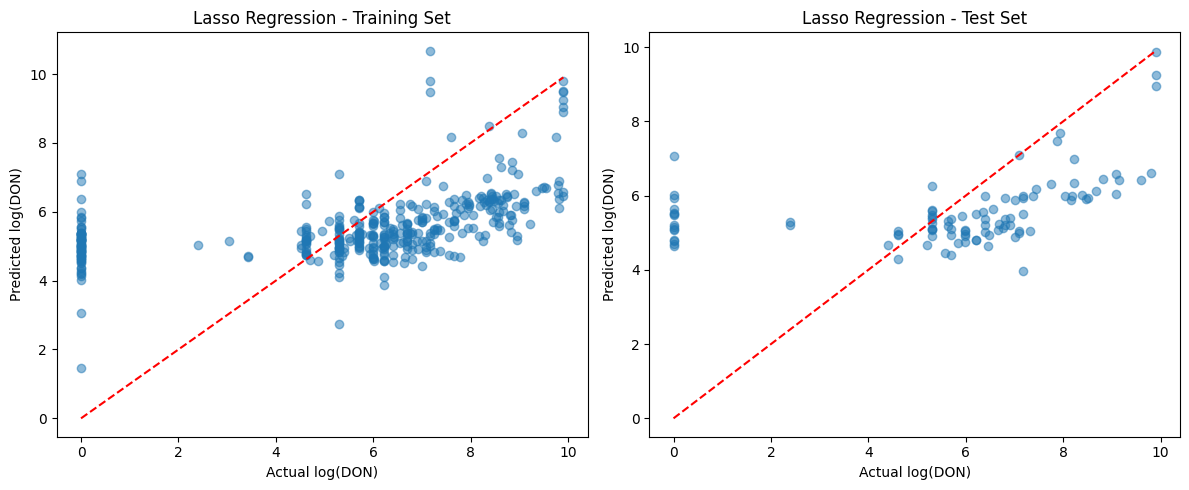

In [38]:
plot_predictions(y_train, predict(lasso_model.best_estimator_, X_train),
                y_test, predict(lasso_model.best_estimator_, X_test),
                "Lasso Regression")

/Users/hardikkamboj/Desktop/projects/imagoAI/src/utils/visualization.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Abs Coefficient', x='Feature Index',


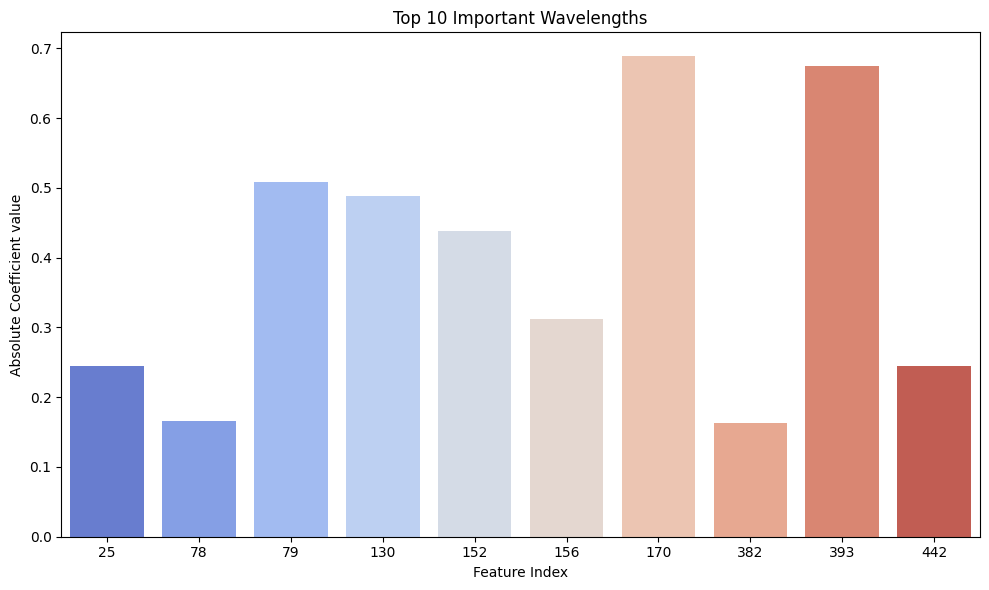

In [39]:
### Featuer importance using lasso regression 

non_zero_coef = lasso_model.best_estimator_.coef_ != 0
if non_zero_coef.any():
    feature_indices = np.where(non_zero_coef)[0]
    coefficients = lasso_model.best_estimator_.coef_[non_zero_coef]
    plot_feature_importance(feature_indices, coefficients)

We can see from the graph above that the best feature with index 170 has the best "absolute" coeffiecient values, followed by feature index 393, and then 79. 

## XG Boost 

In [40]:
xgb_model = XGBoostModel.get_model()

The line below will take some time. 
To reduce the search space, consider going to config.py and changing the search parameters 

In [41]:
#xgb_model.fit(X_train, y_train) 

Trained XG Boost on colab 

## Neural network

In [42]:
regular_nn_params = optimize_hyperparameters(
        NeuralNetwork, 
        train_loader, 
        test_loader,
        n_trials=50  # Adjust number of trials as needed
    )

[I 2025-03-16 17:22:05,044] A new study created in memory with name: no-name-a5ed9ee4-9de2-4004-b45f-7d60d1398b5f
[I 2025-03-16 17:22:09,545] Trial 0 finished with value: 6.177373170852661 and parameters: {'hidden_layer_0': 160, 'hidden_layer_1': 32, 'hidden_layer_2': 96, 'dropout_rate': 0.37613860011805833, 'learning_rate': 0.0062109077361072055}. Best is trial 0 with value: 6.177373170852661.
[I 2025-03-16 17:22:15,660] Trial 1 finished with value: 7.5673657894134525 and parameters: {'hidden_layer_0': 352, 'hidden_layer_1': 448, 'hidden_layer_2': 384, 'dropout_rate': 0.4098981447131015, 'learning_rate': 0.002050004948008496}. Best is trial 0 with value: 6.177373170852661.
[I 2025-03-16 17:22:18,018] Trial 2 finished with value: 6.4551843166351315 and parameters: {'hidden_layer_0': 32, 'hidden_layer_1': 352, 'hidden_layer_2': 288, 'dropout_rate': 0.444577199079227, 'learning_rate': 0.0017484103863985208}. Best is trial 0 with value: 6.177373170852661.
[I 2025-03-16 17:22:20,653] Trial

In [43]:
print("\nBest hyperparameters for Regular Neural Network:")
for param, value in regular_nn_params.items():
    print(f"{param}: {value}")


Best hyperparameters for Regular Neural Network:
hidden_layer_0: 160
hidden_layer_1: 32
hidden_layer_2: 96
dropout_rate: 0.37613860011805833
learning_rate: 0.0062109077361072055


In [44]:
print("\nTraining Regular Neural Network with optimal parameters...")
nn_model, history = train_neural_network_with_optimal_params(
    NeuralNetwork,
    train_loader,
    test_loader,
    regular_nn_params
)


Training Regular Neural Network with optimal parameters...
Early stopping at epoch 109


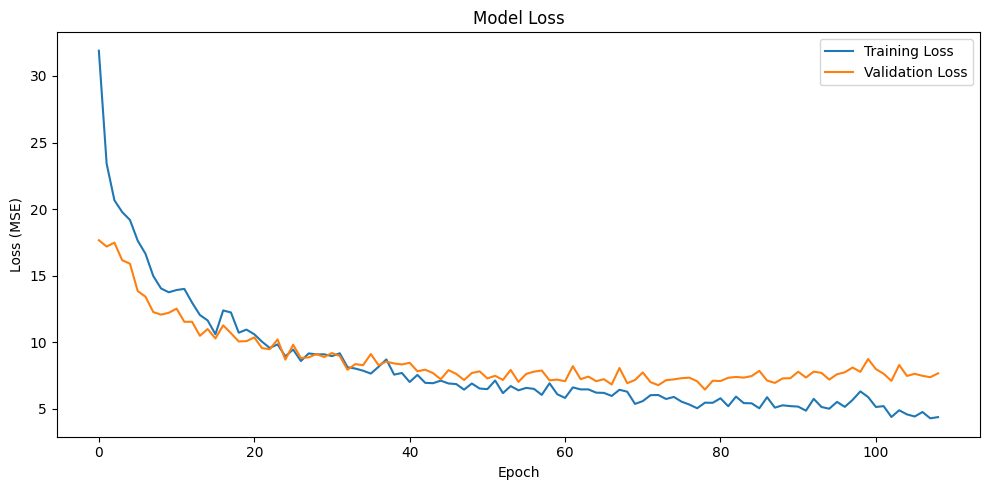

In [45]:
plot_training_history(history)

In [46]:
nn_metrics = evaluate_model(nn_model, X_train, X_test, y_train, y_test, is_neural_net=True)

In [47]:
nn_metrics

{'rmse_train': 1.8038834992805413,
 'rmse_test': 2.766792309986589,
 'r2_train': 0.6230373995432551,
 'r2_test': -0.001383669074908056,
 'mae_train': 1.3881847831638041,
 'mae_test': 2.143874856622684}

In [48]:
models_results.append(("Neural Network (Optimized)", nn_metrics))

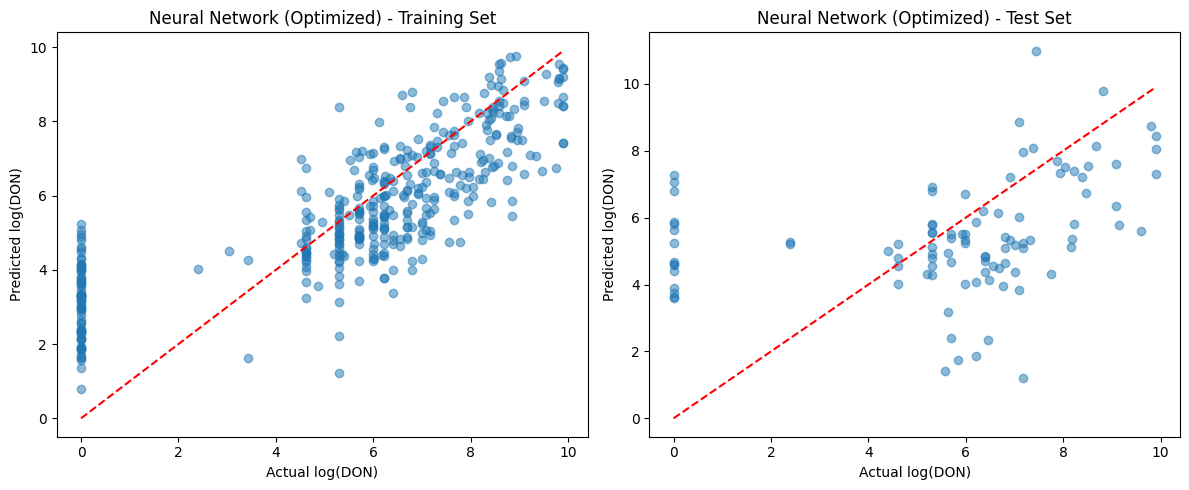

In [49]:
plot_predictions(y_train, predict(nn_model, X_train, is_neural_net=True),
                    y_test, predict(nn_model, X_test, is_neural_net=True),
                    "Neural Network (Optimized)")

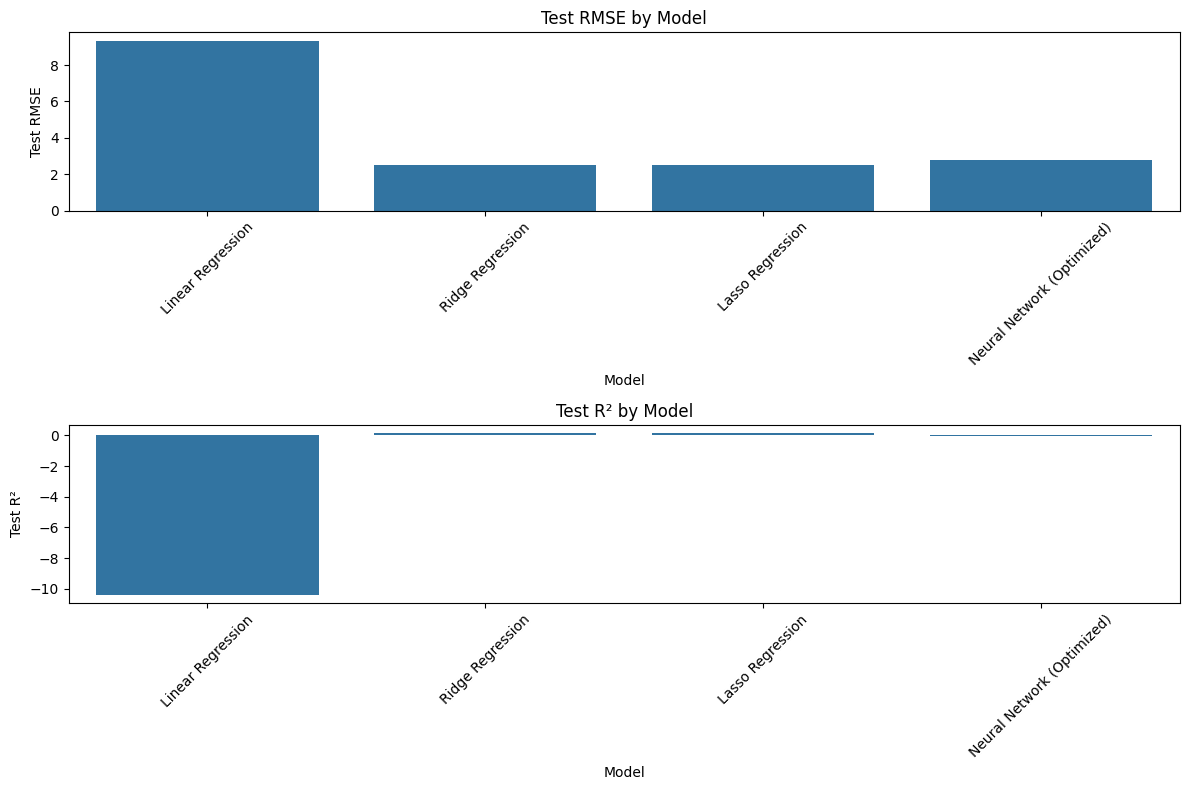

In [50]:
plot_model_comparison(models_results)

In [51]:
torch.save(nn_model.state_dict(), MODEL_PATHS['NEURAL_NET'])
print("Neural Network saved!")

Neural Network saved!


## The current Issue 

- For our use case, low level of DON concentration are useful. They tell us that the current sample is safe for human use.
- Our model is very bad at predicting the samples where the DON concentration are low, and this is an issue. 

## Using Weighted MSE loss to focus more on samples having close to 0 DON concentration

In [52]:
weighted_nn_params = optimize_hyperparameters(
    NeuralNetwork,
    train_loader,
    test_loader,
    is_weighted=True,
    weight_threshold=1.0,  # Adjust based on your data
    n_trials=50  # Adjust number of trials as needed
)

[I 2025-03-16 17:22:32,387] A new study created in memory with name: no-name-103a39ec-c0fa-4ab5-942b-6c6cf7d4c52c
[I 2025-03-16 17:22:35,798] Trial 0 finished with value: 14.305769901275635 and parameters: {'hidden_layer_0': 32, 'hidden_layer_1': 416, 'hidden_layer_2': 448, 'dropout_rate': 0.4310407654929256, 'learning_rate': 0.0014348853728361531, 'weight_factor': 3.4916791290566564}. Best is trial 0 with value: 14.305769901275635.
[I 2025-03-16 17:22:45,874] Trial 1 finished with value: 15.324070262908936 and parameters: {'hidden_layer_0': 320, 'hidden_layer_1': 288, 'hidden_layer_2': 512, 'dropout_rate': 0.2380351916040281, 'learning_rate': 3.487853345681587e-05, 'weight_factor': 2.821267462020503}. Best is trial 0 with value: 14.305769901275635.
[I 2025-03-16 17:22:52,100] Trial 2 finished with value: 19.427084541320802 and parameters: {'hidden_layer_0': 32, 'hidden_layer_1': 288, 'hidden_layer_2': 416, 'dropout_rate': 0.3792881564982601, 'learning_rate': 2.7315097458305713e-05, 'w

In [53]:
print("\nBest hyperparameters for Weighted Neural Network:")
for param, value in weighted_nn_params.items():
    print(f"{param}: {value}")


Best hyperparameters for Weighted Neural Network:
hidden_layer_0: 512
hidden_layer_1: 480
hidden_layer_2: 160
dropout_rate: 0.20641838474429178
learning_rate: 0.008779323533239297
weight_factor: 1.552272542311587


In [54]:
print("\nTraining Weighted Neural Network with optimal parameters...")
weighted_nn_model, weighted_history = train_neural_network_with_optimal_params(
    NeuralNetwork,
    train_loader,
    test_loader,
    weighted_nn_params,
    is_weighted=True,
    weight_threshold=1.0  # Same threshold as used in optimization
)


Training Weighted Neural Network with optimal parameters...
Epoch [10/200], Train Loss: 12.5397, Val Loss: 14.1033
Epoch [20/200], Train Loss: 9.5652, Val Loss: 11.8116
Epoch [30/200], Train Loss: 7.6781, Val Loss: 13.5370
Epoch [40/200], Train Loss: 5.1007, Val Loss: 10.7463
Epoch [50/200], Train Loss: 4.8005, Val Loss: 10.0803
Epoch [60/200], Train Loss: 4.9003, Val Loss: 11.4046
Epoch [70/200], Train Loss: 4.1923, Val Loss: 10.6850
Early stopping at epoch 80


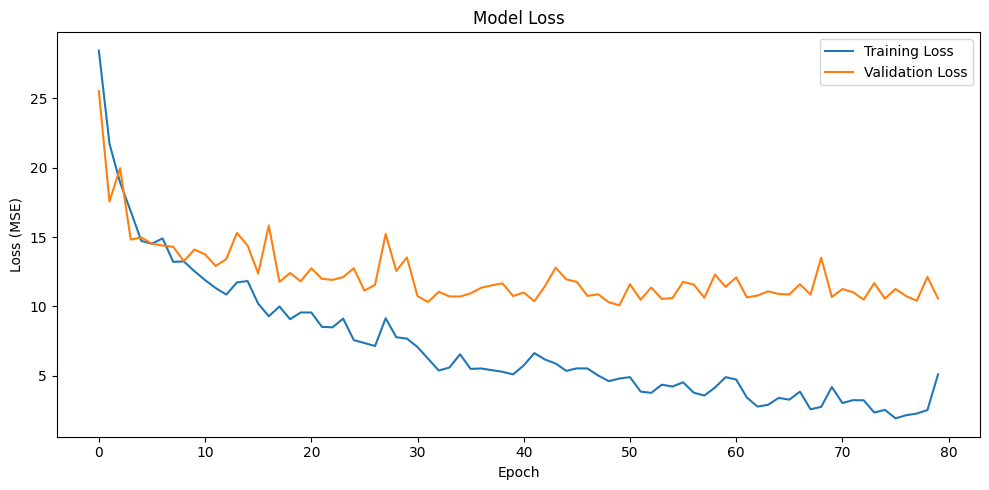

In [55]:
plot_training_history(weighted_history)

In [56]:
weighted_nn_metrics = evaluate_model(weighted_nn_model, X_train, X_test, y_train, y_test, is_neural_net=True)

In [57]:
weighted_nn_metrics

{'rmse_train': 1.449900554530924,
 'rmse_test': 2.9244307615867506,
 'r2_train': 0.756467052687712,
 'r2_test': -0.11874233213568197,
 'mae_train': 1.0569504317846634,
 'mae_test': 2.236951074292642}

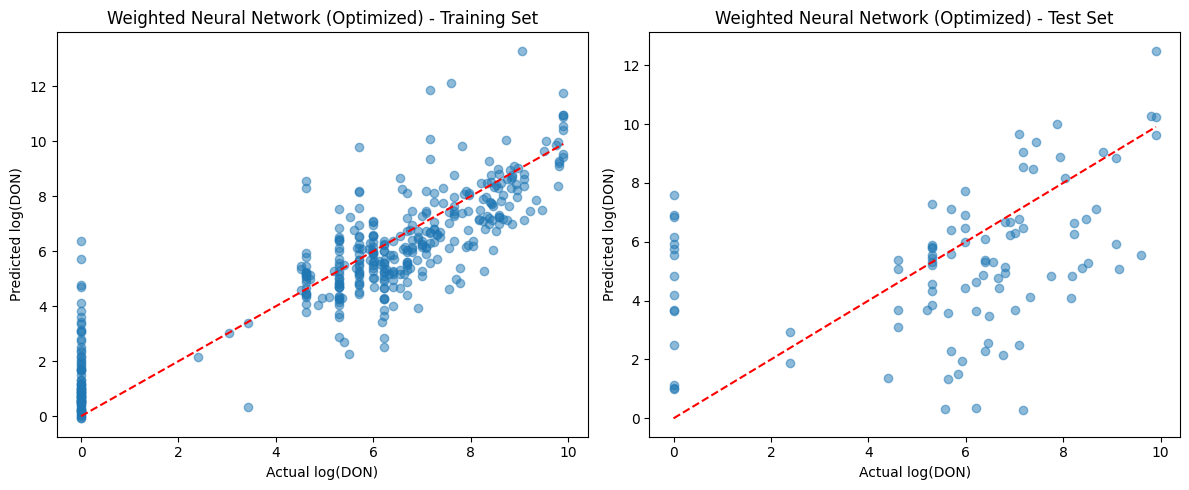

In [58]:
models_results.append(("Weighted Neural Network (Optimized)", weighted_nn_metrics))
plot_predictions(y_train, predict(weighted_nn_model, X_train, is_neural_net=True),
                    y_test, predict(weighted_nn_model, X_test, is_neural_net=True),
                    "Weighted Neural Network (Optimized)")

In [59]:
# save model weights 

model_info = {
    'state_dict': nn_model.state_dict(),
    'hyperparameters': regular_nn_params
}
torch.save(model_info, MODEL_PATHS['NEURAL_NET'])
print("Regular Neural Network saved with hyperparameters!")

Regular Neural Network saved with hyperparameters!


In [60]:
weighted_model_info = {
    'state_dict': weighted_nn_model.state_dict(),
    'hyperparameters': weighted_nn_params
}
weighted_model_path = MODEL_PATHS['NEURAL_NET'].replace('.pth', '_weighted.pth')
torch.save(weighted_model_info, weighted_model_path)
print("Weighted Neural Network saved with hyperparameters!")

Weighted Neural Network saved with hyperparameters!


### What can be tried now - 

## A two stage network

The previous implementation of neural network with weighted loss function was able to get better prediction for samples with DON concentration = 0, but it's still not enough. Let's try a two stage model. The first will be a classifies, and than a regressor. 